<a href="https://colab.research.google.com/github/Joboreh97/demo-repo/blob/main/tutorials/phy/Autoencoder_QAT_tflite_method_functionalstyle_demapper_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Learning with Autoencoders

In this notebook, you will learn how to implement an end-to-end communication system as an autoencoder [1].
The implemented system is shown in the figure below.
An additive white Gaussian noise (AWGN) channel is considered.
On the transmitter side, joint training of the constellation geometry and bit-labeling is performed, as in [2].
On the receiver side, a neural network-based demapper that computes log-likelihood ratios (LLRs) on the transmitted bits from the received samples is optimized.
The considered autoencoder is benchmarked against a quadrature amplitude modulation (QAM) with Gray labeling and the optimal AWGN demapper.

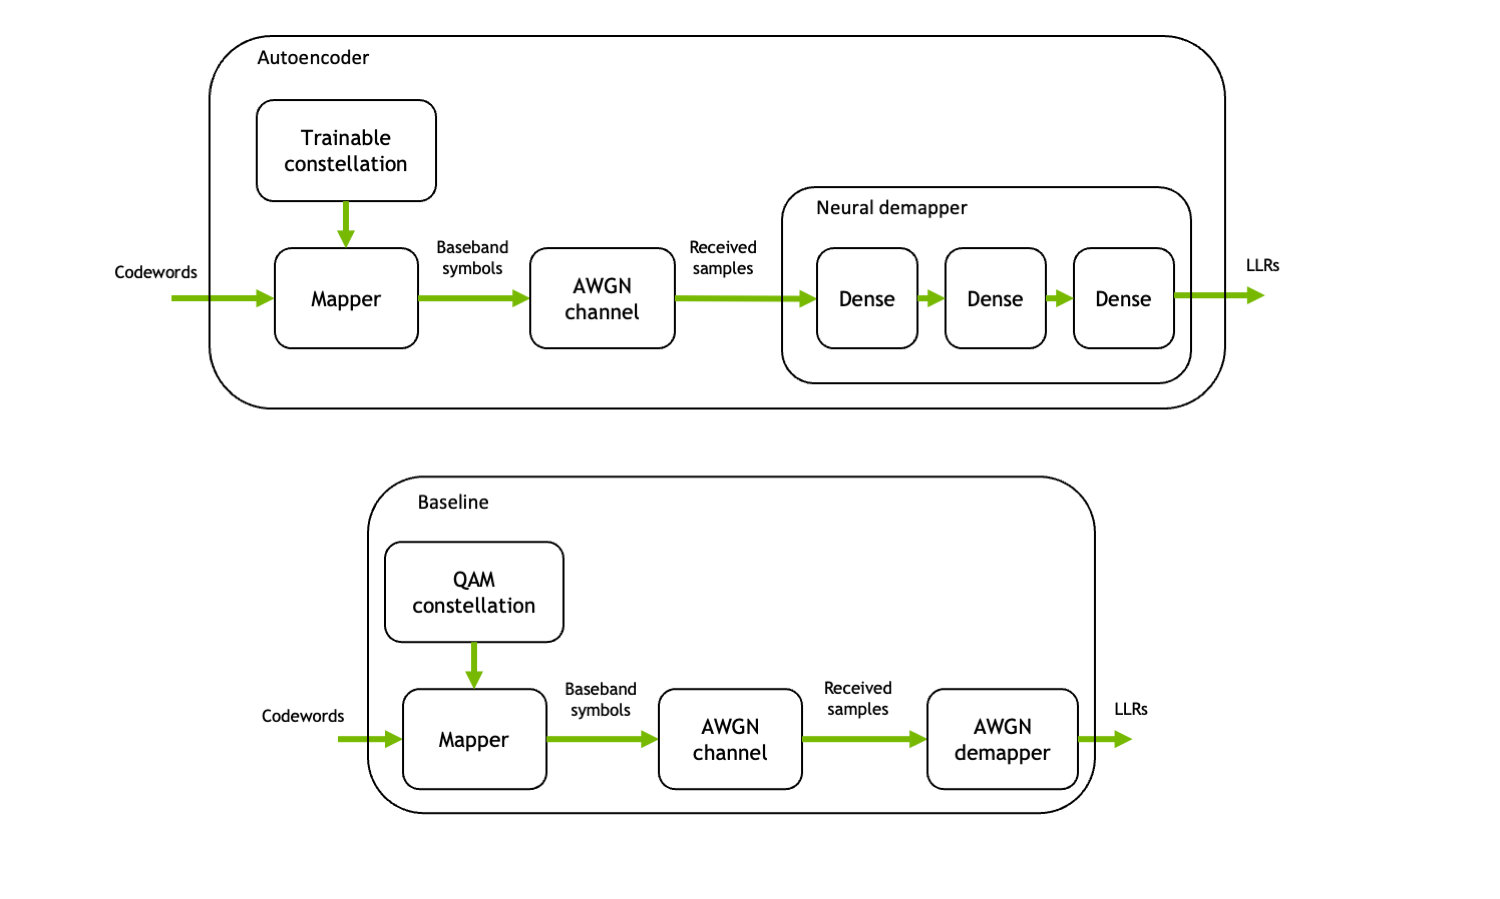


Two algorithms for training the autoencoder are implemented in this notebook:

* Conventional stochastic gradient descent (SGD) with backpropagation, which assumes a differentiable channel model and therefore optimizes the end-to-end system by backpropagating the gradients through the channel (see, e.g., [1]).
* The training algorithm from [3], which does not assume a differentiable channel model, and which trains the end-to-end system by alternating between conventional training of the receiver and reinforcement learning (RL)-based training of the transmitter. Compared to [3], an additional step of fine-tuning of the receiver is performed after alternating training.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Neural Demapper](#Neural-Demapper)
* [Trainable End-to-end System: Conventional Training](#Trainable-End-to-end-System:-Conventional-Training)
* [Trainable End-to-end System: RL-based Training](#Trainable-End-to-end-System:-RL-based-Training)
* [Evaluation](#Evaluation)
* [Visualizing the Learned Constellations](#Visualizing-the-Learned-Constellations)
* [References](#References)

## GPU Configuration and Imports

In [54]:
!pip show tensorflow
!pip show tf_keras

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, sionna, tensorflow-text, tensorflow_decision_forests, tf_keras
Name: tf_keras
Version: 2.18.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: tensorflow
Required-by: dopamine_rl, tensorflow-hub, tensorflow_decision_forests


In [55]:
# ✅ Set this before importing TensorFlow to use legacy tf.keras (Keras 2)
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Optional: Set GPU and logging behavior
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Add this to disable XNNPACK delegate for TFLite interpreter:
os.environ["TFLITE_ENABLE_XNNPACK"] = "0"
os.environ["TFLITE_DISABLE_SELECT_TF_OPS"] = "1"     # Add this
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"            # Add this too
# ✅ Now import TensorFlow and confirm it's using legacy Keras
import tensorflow as tf
import tf_keras
print("Legacy tf_keras version:", tf_keras.__version__)  # Should print 2.18.0

# ✅ Sionna setup
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
        print("Installing Sionna and restarting the runtime. Please run the cell again.")
        os.system("pip install sionna")
        os.kill(os.getpid(), 5)
    else:
        raise e

# ✅ GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# ✅ Suppress warnings from TF logger
tf.get_logger().setLevel('ERROR')

# ✅ Imports from tf.keras instead of standalone keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense

# ✅ Sionna imports
from sionna.phy import Block
from sionna.phy.channel import AWGN
from sionna.phy.utils import ebnodb2no, log10, expand_to_rank
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, Constellation, BinarySource
from sionna.phy.utils import sim_ber

# ✅ Seed
sionna.phy.config.seed = 42

# ✅ Jupyter/plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle


Legacy tf_keras version: 2.18.0


In [56]:
!pip install tensorflow-model-optimization

## Simulation Parameters

In [57]:
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = 4.0
ebno_db_max = 8.0

###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 6 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.5 # Coderate for the outer code
n = 1500 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
num_symbols_per_codeword = n//num_bits_per_symbol # Number of modulated baseband symbols per codeword
k = int(n*coderate) # Number of information bits per codeword

###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 1000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 700
num_training_iterations_rl_finetuning = 300
training_batch_size = tf.constant(128, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter
model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_qat = "awgn_autoencoder_weights_qat" # Filename to save the autoencoder weights once QAT is done
model_weights_path_quantized_conventional_training = "awgn_autoencoder_quantized_weights_conventional_training"
model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation configuration
###############################################
results_filename = "awgn_autoencoder_results" # Location to save the results

## Neural Demapper

The neural network-based demapper shown in the figure above is made of three dense layers with ReLU activation.

The input of the demapper consists of a received sample $y \in \mathbb{C}$ and the noise power spectral density $N_0$ in log-10 scale to handle different orders of magnitude for the SNR.

As the neural network can only process real-valued inputs, these values are fed as a 3-dimensional vector

$$\left[ \mathcal{R}(y), \mathcal{I}(y), \log_{10}(N_0) \right]$$

where $\mathcal{R}(y)$ and $\mathcal{I}(y)$ refer to the real and imaginary component of $y$, respectively.

The output of the neural network-based demapper consists of LLRs on the `num_bits_per_symbol` bits mapped to a constellation point. Therefore, the last layer consists of ``num_bits_per_symbol`` units.

**Note**: The neural network-based demapper processes the received samples $y$ forming a block individually. The [neural receiver notebook](https://nvlabs.github.io/sionna/phy/tutorials/Neural_Receiver.html) provides an example of a more advanced neural network-based receiver that jointly processes a resource grid of received symbols.

In [58]:
# import tensorflow as tf

# def preprocess_complex_input(y, no, num_symbols_per_codeword):
#     def log10_fn(x):
#         return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

#     no_db = log10_fn(no)
#     no_db = tf.tile(no_db, [1, num_symbols_per_codeword])
#     re = tf.math.real(y)
#     im = tf.math.imag(y)
#     z = tf.stack([re, im, no_db], axis=-1)  # shape: [batch_size, num_symbols, 3]
#     return z


In [59]:
def preprocess_complex_input(y, no, num_symbols_per_codeword):
    def log10_fn(x):
        return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

    no_db = log10_fn(no)  # shape: [batch_size, 1]
    re = tf.math.real(y)  # shape: [batch_size, num_symbols_per_codeword]
    im = tf.math.imag(y)

    # Broadcast no_db to match shape of re: [batch_size, num_symbols_per_codeword]
    no_db = tf.broadcast_to(no_db, tf.shape(re))

    # Stack into shape: [batch_size, num_symbols_per_codeword, 3]
    z = tf.stack([re, im, no_db], axis=-1)
    return z

In [60]:
from tensorflow.keras.layers import Input, Dense

def create_functional_demapper_real_input(num_symbols_per_codeword, num_bits_per_symbol):
    z_input = Input(shape=(num_symbols_per_codeword, 3), dtype=tf.float32, name="z_input")
    x = Dense(128, activation="relu")(z_input)
    x = Dense(128, activation="relu")(x)
    llr = Dense(num_bits_per_symbol)(x)
    return Model(inputs=z_input, outputs=llr, name="FunctionalDemapperReal")



In [61]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class NeuralDemapper(Layer):

    def __init__(self):
        super().__init__()

        self._dense_1 = Dense(128, 'relu')
        self._dense_2 = Dense(128, 'relu')
        self._dense_3 = Dense(num_bits_per_symbol, None) # The feature correspond to the LLRs for every bits carried by a symbol

    def call(self, y, no):

        # Using log10 scale helps with the performance
        no_db = log10(no)

        # Stacking the real and imaginary components of the complex received samples
        # and the noise variance
        no_db = tf.tile(no_db, [1, num_symbols_per_codeword]) # [batch size, num_symbols_per_codeword]
        z = tf.stack([tf.math.real(y),
                      tf.math.imag(y),
                      no_db], axis=2) # [batch size, num_symbols_per_codeword, 3]
        llr = self._dense_1(z)
        llr = self._dense_2(llr)
        llr = self._dense_3(llr) # [batch size, num_symbols_per_codeword, num_bits_per_symbol]

        return llr

In [62]:
print("Legacy tf_keras version:", tf_keras.__version__)

Legacy tf_keras version: 2.18.0


In [63]:
import tensorflow_model_optimization as tfmot

# Float32 demapper
float_demapper = create_functional_demapper_real_input(
    num_symbols_per_codeword, num_bits_per_symbol)

# QAT wrapper
qat_demapper_model = tfmot.quantization.keras.quantize_model(float_demapper)



## Trainable End-to-end System: Conventional Training

The following cell defines an end-to-end communication system that transmits bits modulated using a trainable constellation over an AWGN channel.

The receiver uses the previously defined neural network-based demapper to compute LLRs on the transmitted (coded) bits.

As in [1], the constellation and neural network-based demapper are jointly trained through SGD and backpropagation using the binary cross entropy (BCE) as loss function.

Training on the BCE is known to be equivalent to maximizing an achievable information rate [2].

The following model can be instantiated either for training (`training = True`) or evaluation (`training = False`).

In the former case, the BCE is returned and no outer code is used to reduce computational complexity and as it does not impact the training of the constellation or demapper.

When setting `training` to `False`, an LDPC outer code from 5G NR is applied.

In [64]:
class E2ESystemConventionalTraining(Model):

    def __init__(self, training):
        super().__init__()

        self._training = training

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        if not self._training:
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

        # Fixed constellation points (untrainable)
        qam_points = Constellation("qam", num_bits_per_symbol).points
        self.constellation = Constellation("custom",
                                           num_bits_per_symbol,
                                           points=qam_points,
                                           normalize=True,
                                           center=True)

        # No trainable variables for constellation points here!

        self._mapper = Mapper(constellation=self.constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        # Functional demapper remains trainable
        self._demapper = float_demapper

        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

        #################
        # Loss function
        #################
        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, batch_size, ebno_db):
        # No reassignment of constellation points needed — points fixed at init

        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db) if len(ebno_db.shape) == 0 else ebno_db

        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)
        ################
        ## Transmitter
        ################
        if self._training:
            c = self._binary_source([batch_size, n])
        else:
            b = self._binary_source([batch_size, k])
            c = self._encoder(b)
        x = self._mapper(c)

        ################
        ## Channel
        ################
        y = self._channel(x, no)

        ################
        ## Receiver
        ################
        z = preprocess_complex_input(y, no, num_symbols_per_codeword)
        llr = self._demapper(z)

        llr = tf.reshape(llr, [batch_size, n])
        if self._training:
            loss = self._bce(c, llr)
            return loss
        else:
            b_hat = self._decoder(llr)
            return b, b_hat



 # Ground truth and reconstructed information bits returned for BER/BLER computation

A simple training loop is defined in the next cell, which performs `num_training_iterations_conventional` training iterations of SGD. Training is done over a range of SNR, by randomly sampling a batch of SNR values at each iteration.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

In [65]:
# def conventional_training(model):
#     # Optimizer used to apply gradients
#     optimizer = tf.keras.optimizers.Adam()

#     @tf.function(jit_compile=True)
#     def train_step():
#         # Sampling a batch of SNRs
#         ebno_db = tf.random.uniform(shape=[training_batch_size], minval=ebno_db_min, maxval=ebno_db_max)
#         # Forward pass
#         with tf.GradientTape() as tape:
#             loss = model(training_batch_size,  ebno_db)
#         # Computing and applying gradients
#         weights = model.trainable_variables
#         grads = tape.gradient(loss, weights)
#         optimizer.apply_gradients(zip(grads, weights))
#         return loss

#     for i in range(num_training_iterations_conventional):
#         loss = train_step()
#         # Printing periodically the progress
#         if i % 100 == 0:
#             print('Iteration {}/{}  BCE: {:.4f}'.format(i, num_training_iterations_conventional, loss.numpy()), end='\r')

In [66]:
def conventional_training(model):
    # Optimizer used to apply gradients
    optimizer = tf.keras.optimizers.Adam()

    @tf.function(jit_compile=True)
    def train_step():
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[training_batch_size], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            loss = model(training_batch_size,  ebno_db)
        # Computing and applying gradients
        weights = model.trainable_variables
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        return loss

    for i in range(num_training_iterations_conventional):
        loss = train_step()
        # Check for NaNs in model weights
        for w in model.trainable_variables:
            if tf.math.reduce_any(tf.math.is_nan(w)):
                print(f"NaN detected in weights at iteration {i}!")
                return  # Stop training if NaN detected
        if i % 100 == 0:
            print(f"Iteration {i}/{num_training_iterations_conventional} BCE: {loss.numpy():.4f}", end='\r')

In [67]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

In [68]:
def load_weights(model, model_weights_path):
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)


The next cell defines a utility function for saving the weights using [pickle](https://docs.python.org/3/library/pickle.html).

In the next cell, an instance of the model defined previously is instantiated and trained.

In [69]:

# 1️⃣ Train and save original (unquantized) model
model_float = E2ESystemConventionalTraining(training=True)
conventional_training(model_float)

# Save only unquantized weights
save_weights(model_float, model_weights_path_conventional_training)
# Save full model (architecture + weights + config)
#model_float.save("awgn_autoencoder_model.keras")

In [70]:
# 2️⃣ Evaluate conventional model from fresh weights
model_conventional = E2ESystemConventionalTraining(training=False)
load_weights(model_conventional, model_weights_path_conventional_training)





In [71]:
model_conventional.get_weights()

[array([[-1.77014381e-01,  4.84094908e-03, -2.69353598e-01,
         -2.16442749e-01, -3.05900633e-01,  1.38088036e-03,
          5.12647092e-01, -3.37731130e-02,  2.35253721e-01,
          2.50286222e-01,  2.43792474e-01,  3.53784710e-01,
          3.23578626e-01,  3.25270509e-03, -2.97915041e-01,
         -3.26688528e-01,  2.43622288e-01,  6.61738589e-03,
          5.77056361e-03, -2.82426417e-01,  3.33204627e-01,
         -1.75462037e-01, -1.07438548e-03, -1.09361007e-03,
         -1.16347402e-01,  3.60054523e-01, -1.97156429e-01,
         -2.18638103e-03,  3.17369044e-01,  3.03702176e-01,
          1.86781958e-01,  2.38673910e-01, -3.06190434e-03,
         -2.20003635e-01,  3.08343917e-01,  1.30733475e-01,
          7.09794238e-02,  2.65574843e-01,  3.41159731e-01,
          7.69078312e-03, -1.56526819e-01,  1.94876164e-04,
         -3.79408598e-01,  4.08601195e-01, -2.91223794e-01,
         -2.19134718e-01,  3.74816298e-01,  6.00115247e-02,
         -2.67579556e-01, -4.13305223e-0

In [72]:
import tensorflow as tf

class E2ESystemConventionalTraining_Pruned(tf.keras.Model):
    def __init__(self, num_symbols_per_codeword, num_bits_per_symbol, n, pruning_params):
        super().__init__()
        self.n = n
        self._demapper = create_functional_demapper_real_input(num_symbols_per_codeword, num_bits_per_symbol)

    def call(self, inputs, training=None):
        z, _ = inputs  # z: [batch, num_symbols_per_codeword, 3]
        llr = self._demapper(z)  # [batch, num_symbols_per_codeword, num_bits_per_symbol]
        # Reshape to [batch, n]
        llr = tf.reshape(llr, [tf.shape(z)[0], -1])
        return llr


In [73]:
# Example: initialize all required objects
binary_source = BinarySource()
encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)  # or None if not used
qam_points = Constellation("qam", num_bits_per_symbol).points
constellation = Constellation("custom", num_bits_per_symbol, points=qam_points, normalize=True, center=True)
mapper = Mapper(constellation=constellation)
channel = AWGN()
# preprocess_complex_input: your function as before




In [74]:
def synthetic_data_generator(batch_size, num_symbols_per_codeword, num_bits_per_symbol, n, k,
                            coderate, qam_points, constellation, mapper, encoder, channel, preprocess_complex_input, ebno_db_min, ebno_db_max):
    while True:
        # 1. Generate random Eb/No values for each batch
        ebno_db = np.random.uniform(ebno_db_min, ebno_db_max, size=(batch_size,)).astype(np.float32)
        # 2. Generate random information bits of length k
        b = np.random.randint(0, 2, size=(batch_size, k)).astype(np.float32)
        # 3. Encode to codeword length n
        if encoder is not None:
            c = encoder(b)
        else:
            c = b  # If no encoder, treat as codeword
        # 4. Map to constellation
        x = mapper(c)
        # 5. Calculate noise variance per batch
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)
        # 6. Pass through AWGN channel
        y = channel(x, no)
        # 7. Preprocess (convert complex to real-valued input for demapper)
        z = preprocess_complex_input(y, no, num_symbols_per_codeword)
        c_reshaped = np.reshape(c, (batch_size, num_symbols_per_codeword, num_bits_per_symbol))
        yield z, c_reshaped



In [75]:
batch_size = 128  # or whatever value you want

train_dataset = tf.data.Dataset.from_generator(
    lambda: synthetic_data_generator(
        batch_size, num_symbols_per_codeword, num_bits_per_symbol, n, k,
        coderate, qam_points, constellation, mapper, encoder, channel, preprocess_complex_input, ebno_db_min, ebno_db_max
    ),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, num_symbols_per_codeword, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, num_symbols_per_codeword, num_bits_per_symbol), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)


In [76]:
optimizer = tf.keras.optimizers.Adam()
qat_demapper_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)


qat_demapper_model.fit(
    train_dataset,
    steps_per_epoch=1000,  # or as needed
    epochs=1
)

qat_demapper_model.save_weights('qat_demapper_qat_weights.h5')


1000/1000 [==============================] - 207s 206ms/step - loss: 0.3309


In [77]:
class E2ESystemConventionalTrainingQat(Model):

    def __init__(self, training):
        super().__init__()

        self._training = training

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        if not self._training:
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

        # Fixed constellation points (untrainable)
        qam_points = Constellation("qam", num_bits_per_symbol).points
        self.constellation = Constellation("custom",
                                           num_bits_per_symbol,
                                           points=qam_points,
                                           normalize=True,
                                           center=True)

        # No trainable variables for constellation points here!

        self._mapper = Mapper(constellation=self.constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        # Functional demapper remains trainable
        self._demapper = float_demapper
        self._demapper = tfmot.quantization.keras.quantize_model(self._demapper)
        self._demapper.load_weights('qat_demapper_qat_weights.h5') # Load trained weights
        self._demapper.trainable = False

        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

        #################
        # Loss function
        #################
        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, batch_size, ebno_db):
        # No reassignment of constellation points needed — points fixed at init

        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db) if len(ebno_db.shape) == 0 else ebno_db

        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        if self._training:
            c = self._binary_source([batch_size, n])
        else:
            b = self._binary_source([batch_size, k])
            c = self._encoder(b)
        x = self._mapper(c)

        ################
        ## Channel
        ################
        y = self._channel(x, no)

        ################
        ## Receiver
        ################
        z = preprocess_complex_input(y, no, num_symbols_per_codeword)
        llr = self._demapper(z)

        llr = tf.reshape(llr, [batch_size, n])
        if self._training:
            loss = self._bce(c, llr)
            return loss
        else:
            b_hat = self._decoder(llr)
            return b, b_hat


In [78]:

# QAT training model
model_qat = E2ESystemConventionalTrainingQat(training=True)
conventional_training(model_qat)
save_weights(model_qat, model_weights_path_qat)

# Save full model (architecture + weights + config)
#model_float.save("awgn_autoencoder_qat_model.keras")

In [79]:
# Update representative dataset to match uint8 input type
def representative_data_gen():
    for _ in range(100):
        # Use float32, matching the model input
        dummy_input = np.random.randn(1, num_symbols_per_codeword, 3).astype(np.float32)
        yield [dummy_input]


In [80]:
!pip install -U tensorflow-model-optimization


In [81]:
def manually_strip_fake_quant_layers(model):
    import tensorflow as tf
    import tensorflow_model_optimization as tfmot

    # Dynamically locate QuantizeWrapper class
    QuantizeWrapper = None
    for attr in dir(tfmot.quantization.keras):
        obj = getattr(tfmot.quantization.keras, attr)
        if isinstance(obj, type) and "QuantizeWrapper" in obj.__name__:
            QuantizeWrapper = obj
            break
    if QuantizeWrapper is None:
        raise ImportError("QuantizeWrapper not found in tfmot.quantization.keras")

    def _clone_layer(layer):
        if isinstance(layer, QuantizeWrapper):
            # Extract the original layer
            original_layer = layer.layer

            # Fix any wrapped QuantizeAwareActivation
            config = original_layer.get_config()
            if 'activation' in config and isinstance(config['activation'], dict):
                act_cfg = config['activation']
                if 'class_name' in act_cfg and act_cfg['class_name'] == 'QuantizeAwareActivation':
                    config['activation'] = act_cfg['config']['activation']  # e.g., 'relu'
            return original_layer.__class__.from_config(config)

        return layer

    return tf.keras.models.clone_model(model, clone_function=_clone_layer)




In [82]:
# from tensorflow_model_optimization.python.core.quantization.keras.quantizers import AllValuesQuantizer

# custom_objects = {
#     'AllValuesQuantizer': AllValuesQuantizer
# }


In [83]:
# import tensorflow as tf
# import tensorflow_model_optimization as tfmot
# from tensorflow_model_optimization.python.core.quantization.keras.quantizers import AllValuesQuantizer
# from keras.utils import custom_object_scope

# def manually_strip_fake_quant_layers(model):
#     # Dynamically find QuantizeWrapper
#     QuantizeWrapper = None
#     for attr in dir(tfmot.quantization.keras):
#         obj = getattr(tfmot.quantization.keras, attr)
#         if isinstance(obj, type) and "QuantizeWrapper" in obj.__name__:
#             QuantizeWrapper = obj
#             break
#     if QuantizeWrapper is None:
#         raise ImportError("QuantizeWrapper not found in tfmot.quantization.keras")

#     def _clone_layer(layer):
#         if isinstance(layer, QuantizeWrapper):
#             original_layer = layer.layer
#             config = original_layer.get_config()

#             # Fix activation
#             if 'activation' in config and isinstance(config['activation'], dict):
#                 act_cfg = config['activation']
#                 if act_cfg.get('class_name') == 'QuantizeAwareActivation':
#                     config['activation'] = act_cfg['config']['activation']

#             new_layer = original_layer.__class__.from_config(config)
#             new_layer.build(original_layer.input_shape)
#             new_layer.set_weights(original_layer.get_weights())
#             return new_layer
#         else:
#             new_layer = layer.__class__.from_config(layer.get_config())
#             new_layer.build(layer.input_shape)
#             new_layer.set_weights(layer.get_weights())
#             return new_layer

#     with custom_object_scope({'AllValuesQuantizer': AllValuesQuantizer}):
#         stripped_model = tf.keras.models.clone_model(model, clone_function=_clone_layer)

#     return stripped_model


In [84]:
# stripped_model = manually_strip_fake_quant_layers(qat_demapper_model)

In [85]:
#demapper_model = create_functional_demapper_real_input(num_symbols_per_codeword, num_bits_per_symbol)
# 3️⃣ Build the QAT model (important step)
# Build the QAT demapper with the correct input shape
# from tensorflow_model_optimization.quantization.keras import strip_quantization


#qat_demapper_model(tf.zeros([1, num_symbols_per_codeword, 3]))
  # Dummy input to build
model_temp = E2ESystemConventionalTrainingQat(training=False)
load_weights(model_temp, model_weights_path_qat)
# #qat_demapper_model.save("qat_demapper_model.keras")

# Your QAT-trained demapper
# stripped_model = manually_strip_fake_quant_layers(qat_demapper_model)


In [86]:
model_temp.get_weights()

[-2.4058943,
 2.2791848,
 -1,
 array([[-1.76925316e-01,  2.60954956e-03, -2.65573502e-01,
         -2.25206256e-01, -3.12476009e-01, -2.30928650e-03,
          5.34976482e-01, -2.01217920e-01,  2.36557320e-01,
          2.71232545e-01,  2.58509278e-01,  3.58656943e-01,
          3.31438720e-01,  1.09407455e-02, -3.38328034e-01,
         -3.26845109e-01,  2.31670603e-01,  1.14749372e-02,
          4.82770521e-03, -2.79804468e-01,  3.12959343e-01,
         -1.79817826e-01,  4.39519621e-03, -5.32134343e-03,
         -1.55399933e-01,  3.45583439e-01, -1.95284113e-01,
         -9.34991706e-03,  3.02882522e-01,  3.13909799e-01,
          2.04850182e-01,  2.42543757e-01,  1.90455245e-03,
         -2.40411714e-01,  3.17176491e-01,  1.35406077e-01,
          7.31673986e-02,  2.58892655e-01,  3.28947037e-01,
          7.19014183e-03, -1.66257575e-01,  6.64856471e-03,
         -3.86545271e-01,  4.43741292e-01, -3.34073663e-01,
         -2.22921431e-01,  3.78758609e-01,  4.43865024e-02,
         -

In [87]:
# # Build and load weights directly into the demapper model
# qat_demapper_model(tf.zeros([1, num_symbols_per_codeword, 3]))  # build
# qat_demapper_model.load_weights(model_weights_path_qat)  # not into model_temp

# # Then strip quantization manually
# stripped_model = manually_strip_fake_quant_layers(qat_demapper_model)


In [88]:
# qat_demapper_model.set_weights(model_temp._demapper.get_weights())

In [89]:
import tensorflow as tf

# Modify converter settings
converter = tf.lite.TFLiteConverter.from_keras_model(qat_demapper_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter._experimental_disable_quant_scale_range_check = True

tflite_quant_model = converter.convert()

# Save quantized TFLite model
with open("quantized_demapper.tflite", "wb") as f:
    f.write(tflite_quant_model)

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [90]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
input_details = interpreter.get_input_details()
print(input_details[0]['dtype'])  # Should be np.float32 or np.uint8


<class 'numpy.int8'>


In [91]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="quantized_demapper.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input dtype:", input_details[0]['dtype'])    # e.g., np.float32 or np.uint8
print("Output dtype:", output_details[0]['dtype'])  # e.g., np.float32 or np.uint8


Input dtype: <class 'numpy.int8'>
Output dtype: <class 'numpy.int8'>


In [92]:
class QuantizedDemapperWrapper(tf.keras.layers.Layer):
    def __init__(self, interpreter_path):
        super().__init__()
        # Force single-threaded CPU execution
        self.interpreter = tf.lite.Interpreter(
            model_path=interpreter_path,
            experimental_delegates=[],
            num_threads=1  # Already correct in your code
        )
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.output_details = self.interpreter.get_output_details()

    def _wrapped_call_single(self, z_single):
      input_scale = self.input_details[0]['quantization'][0]
      input_zero_point = self.input_details[0]['quantization'][1]
      z_quant = np.round(z_single / input_scale + input_zero_point)
      z_quant = np.clip(z_quant, -128, 127).astype(np.int8)
      # Ensure batch dimension is present
      if z_quant.ndim == 2:
          z_quant = np.expand_dims(z_quant, axis=0)
      self.interpreter.set_tensor(self.input_details[0]['index'], z_quant)
      self.interpreter.invoke()
      output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
      output_scale, output_zero_point = self.output_details[0]['quantization']
      output_float = (output_data.astype(np.float32) - output_zero_point) * output_scale
      return output_float[0]


    def call(self, z):
        # z shape: (batch_size, 250, 3)
        return tf.map_fn(
            lambda x: tf.py_function(self._wrapped_call_single, [x], tf.float32),
            z,
            fn_output_signature=tf.TensorSpec(shape=(250, 6), dtype=tf.float32)
        )



In [93]:
model_quantized =E2ESystemConventionalTrainingQat(training=False)
load_weights(model_quantized, model_weights_path_qat)  # load everything else

# Replace demapper with quantized TFLite wrapper
model_quantized._demapper = QuantizedDemapperWrapper("quantized_demapper.tflite")
save_weights(model_quantized, model_weights_path_quantized_conventional_training)


## Trainable End-to-end System: RL-based Training

The following cell defines the same end-to-end system as before, but stop the gradients after the channel to simulate a non-differentiable channel.

To jointly train the transmitter and receiver over a non-differentiable channel, we follow [3], which key idea is to alternate between:

- Training of the receiver on the BCE using conventional backpropagation and SGD.
- Training of the transmitter by applying (known) perturbations to the transmitter output to enable estimation of the gradient of the transmitter weights with respect to an approximation of the loss function.

When `training` is set to `True`, both losses for training the receiver and the transmitter are returned.

In [94]:
class E2ESystemRLTraining(Model):

    def __init__(self, training):
        super().__init__()

        self._training = training

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not self._training:
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

        # Trainable constellation
        # We initialize a custom constellation with qam points
        qam_points = Constellation("qam", num_bits_per_symbol).points
        self.constellation = Constellation("custom",
                                           num_bits_per_symbol,
                                           points=qam_points,
                                           normalize=True,
                                           center=True)
        # To make the constellation trainable, we need to create seperate
        # variables for the real and imaginary parts
        self.points_r = self.add_weight(shape=qam_points.shape,
                                        initializer="zeros")
        self.points_i = self.add_weight(shape=qam_points.shape,
                                        initializer="zeros")
        self.points_r.assign(tf.math.real(qam_points))
        self.points_i.assign(tf.math.imag(qam_points))

        self._mapper = Mapper(constellation=self.constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        # We use the previously defined neural network for demapping
        self._demapper = NeuralDemapper()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    def call(self, batch_size, ebno_db, perturbation_variance=tf.constant(0.0, tf.float32)):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        # Outer coding is only performed if not training
        if self._training:
            c = self._binary_source([batch_size, n])
        else:
            b = self._binary_source([batch_size, k])
            c = self._encoder(b)
        # Modulation
        # Set the constellation points equal to a complex tensor constructed
        # from two real-valued variables
        points = tf.complex(self.points_r, self.points_i)
        self.constellation.points = points
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        # Adding perturbation
        # If ``perturbation_variance`` is 0, then the added perturbation is null
        epsilon_r = tf.random.normal(tf.shape(x))*tf.sqrt(0.5*perturbation_variance)
        epsilon_i = tf.random.normal(tf.shape(x))*tf.sqrt(0.5*perturbation_variance)
        epsilon = tf.complex(epsilon_r, epsilon_i) # [batch size, num_symbols_per_codeword]
        x_p = x + epsilon # [batch size, num_symbols_per_codeword]

        ################
        ## Channel
        ################
        y = self._channel(x_p, no) # [batch size, num_symbols_per_codeword]
        y = tf.stop_gradient(y) # Stop gradient here

        ################
        ## Receiver
        ################
        llr = self._demapper(y, no)

        # If training, outer decoding is not performed
        if self._training:
            # Average BCE for each baseband symbol and each batch example
            c = tf.reshape(c, [-1, num_symbols_per_codeword, num_bits_per_symbol])
            bce = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(c, llr), axis=2) # Avergare over the bits mapped to a same baseband symbol
            # The RX loss is the usual average BCE
            rx_loss = tf.reduce_mean(bce)
            # From the TX side, the BCE is seen as a feedback from the RX through which backpropagation is not possible
            bce = tf.stop_gradient(bce) # [batch size, num_symbols_per_codeword]
            x_p = tf.stop_gradient(x_p)
            p = x_p-x # [batch size, num_symbols_per_codeword] Gradient is backpropagated through `x`
            tx_loss = tf.square(tf.math.real(p)) + tf.square(tf.math.imag(p)) # [batch size, num_symbols_per_codeword]
            tx_loss = -bce*tx_loss/rl_perturbation_var # [batch size, num_symbols_per_codeword]
            tx_loss = tf.reduce_mean(tx_loss)
            return tx_loss, rx_loss
        else:
            llr = tf.reshape(llr, [-1, n]) # Reshape as expected by the outer decoder
            b_hat = self._decoder(llr)
            return b,b_hat

The next cell implements the training algorithm from [3], which alternates between conventional training of the neural network-based receiver, and RL-based training of the transmitter.

In [95]:
def rl_based_training(model):
    # Optimizers used to apply gradients
    optimizer_tx = tf.keras.optimizers.Adam() # For training the transmitter
    optimizer_rx = tf.keras.optimizers.Adam() # For training the receiver

    # Function that implements one transmitter training iteration using RL.
    @tf.function(jit_compile=True)
    def train_tx():
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[training_batch_size], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            # Keep only the TX loss
            tx_loss, _ = model(training_batch_size, ebno_db,
                               tf.constant(rl_perturbation_var, tf.float32)) # Perturbation are added to enable RL exploration
        ## Computing and applying gradients
        weights = tape.watched_variables()
        grads = tape.gradient(tx_loss, weights, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        optimizer_tx.apply_gradients(zip(grads, weights))

    # Function that implements one receiver training iteration
    @tf.function(jit_compile=True)
    def train_rx():
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[training_batch_size], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            # Keep only the RX loss
            _, rx_loss = model(training_batch_size, ebno_db) # No perturbation is added
        ## Computing and applying gradients
        weights = tape.watched_variables()
        grads = tape.gradient(rx_loss, weights, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        optimizer_rx.apply_gradients(zip(grads, weights))
        # The RX loss is returned to print the progress
        return rx_loss

    # Training loop.
    for i in range(num_training_iterations_rl_alt):
        # 10 steps of receiver training are performed to keep it ahead of the transmitter
        # as it is used for computing the losses when training the transmitter
        for _ in range(10):
            rx_loss = train_rx()
        # One step of transmitter training
        train_tx()
        # Printing periodically the progress
        if i % 100 == 0:
            print('Iteration {}/{}  BCE {:.4f}'.format(i, num_training_iterations_rl_alt, rx_loss.numpy()), end='\r')
    print() # Line break

    # Once alternating training is done, the receiver is fine-tuned.
    print('Receiver fine-tuning... ')
    for i in range(num_training_iterations_rl_finetuning):
        rx_loss = train_rx()
        if i % 100 == 0:
            print('Iteration {}/{}  BCE {:.4f}'.format(i, num_training_iterations_rl_finetuning, rx_loss.numpy()), end='\r')

In the next cell, an instance of the model defined previously is instantiated and trained.

## Evaluation

The following cell implements a baseline which uses QAM with Gray labeling and conventional demapping for AWGN channel.

In [96]:
class Baseline(Model):

    def __init__(self):
        super().__init__()

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)
        constellation = Constellation("qam", num_bits_per_symbol, trainable=False)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        self._demapper = Demapper("app", constellation=constellation)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        b = self._binary_source([batch_size, k])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        ################
        ## Channel
        ################
        y = self._channel(x, no) # [batch size, num_symbols_per_codeword]

        ################
        ## Receiver
        ################
        llr = self._demapper(y, no)
        # Outer decoding
        b_hat = self._decoder(llr)
        return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

In [97]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

In [98]:
# # Utility function to load and set weights of a model
# def load_weights(model, model_weights_path):
#     model(tf.cast(1, tf.int32), tf.constant(10.0, tf.float32))
#     with open(model_weights_path, 'rb') as f:
#         weights = pickle.load(f)
#     model.set_weights(weights)
#     points = tf.complex(model.points_r, model.points_i)
#     model.constellation.points = points

The next cell evaluate the baseline and the two autoencoder-based communication systems, trained with different method.
The results are stored in the dictionary ``BLER``.

In [99]:

# Dictionary storing the results
BER = {}

model_baseline = Baseline()
ber, _ = sim_ber(model_baseline, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode="xla")
BER['baseline'] = ber.numpy()

# model_conventional
# ebno_dbs = tf.convert_to_tensor(ebno_dbs, dtype=tf.float32)
# ebno_dbs = tf.reshape(ebno_dbs, [-1])  # Ensure rank-1
ber, _ = sim_ber(model_conventional, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode="xla")
BER['autoencoder-conv'] = ber.numpy()

# model_quantized
# ebno_dbs = tf.convert_to_tensor(ebno_dbs, dtype=tf.float32)
# ebno_dbs = tf.reshape(ebno_dbs, [-1])  # Ensure rank-1
ber, _ = sim_ber(model_quantized, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-quantized'] = ber.numpy()

# # model_rl (if you want BER for RL as well)
# model_rl = E2ESystemRLTraining(training=False)
# load_weights(model_rl, model_weights_path_rl_training)
# ber, _ = sim_ber(model_rl, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000, graph_mode="xla")
# BER['autoencoder-rl'] = ber.numpy()

with open(results_filename, 'wb') as f:
    pickle.dump((ebno_dbs, BER), f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      4.0 | 1.2217e-01 | 1.0000e+00 |       93830 |      768000 |         1024 |        1024 |        20.3 |reached target block errors
      4.5 | 9.7760e-02 | 9.9902e-01 |       75080 |      768000 |         1023 |        1024 |         6.5 |reached target block errors
      5.0 | 5.7765e-02 | 9.0885e-01 |       49909 |      864000 |         1047 |        1152 |         5.5 |reached target block errors
      5.5 | 1.8004e-02 | 5.0098e-01 |       27654 |     1536000 |         1026 |        2048 |        10.9 |reached target block errors
      6.0 | 2.4759e-03 | 1.1136e-01 |       16876 |     6816000 |         1012 |        9088 |        48.4 |reached target block errors
      6.5 | 8.9896e-05 | 8.7500e-03 |         863 |     9600000 |

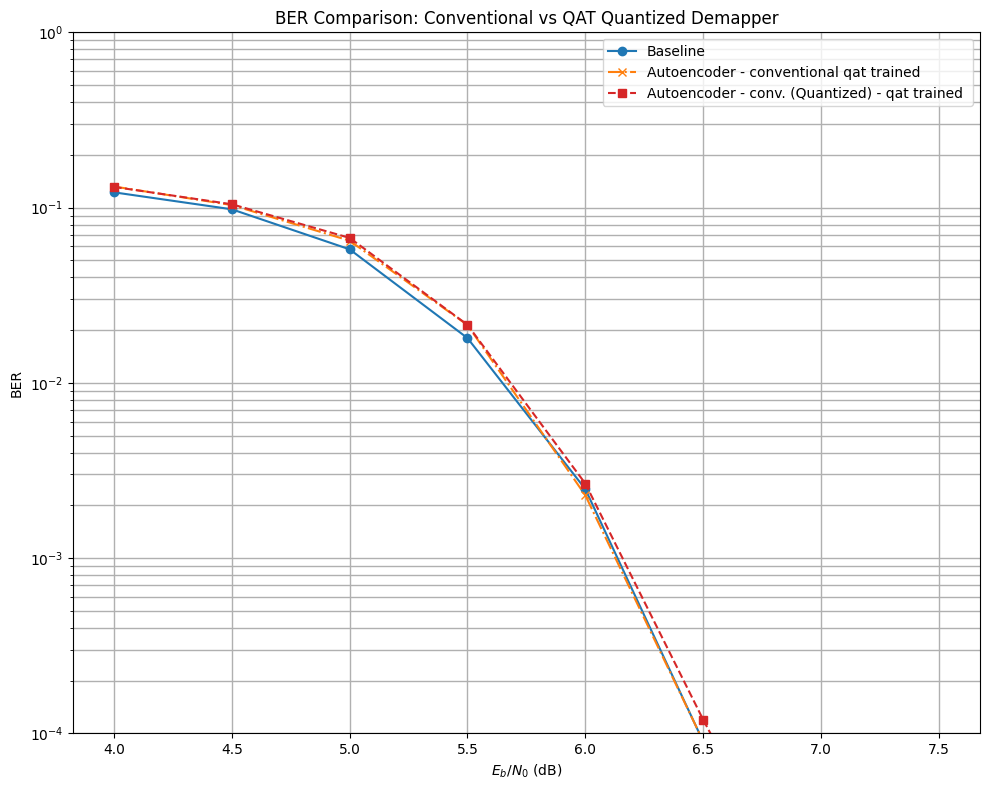

In [100]:
plt.figure(figsize=(10, 8))

# Baseline (e.g., QAM)
plt.semilogy(ebno_dbs, BER['baseline'], 'o-', color='C0', label='Baseline')

# Autoencoder (conventional training)
plt.semilogy(ebno_dbs, BER['autoencoder-conv'], 'x-.', color='C1', label='Autoencoder - conventional qat trained ')

# Autoencoder (quantized demapper)
plt.semilogy(ebno_dbs, BER['autoencoder-quantized'], 's--', color='C3', label='Autoencoder - conv. (Quantized) - qat trained ')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.title("BER Comparison: Conventional vs QAT Quantized Demapper")
plt.grid(True, which="both", linewidth=1.0)
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()
plt.show()



In [101]:
print("Quantized model evaluation:")
for layer in model_quantized.layers:
    print(layer.__class__.__name__)


Quantized model evaluation:
QuantizedDemapperWrapper


In [102]:
# plt.figure(figsize=(10,8))
# # Baseline - Perfect CSI
# plt.semilogy(ebno_dbs, BLER['baseline'], 'o-', c=f'C0', label=f'Baseline')
# # Autoencoder - conventional training
# plt.semilogy(ebno_dbs, BLER['autoencoder-conv'], 'x-.', c=f'C1', label=f'Autoencoder - conventional training')
# # Autoencoder - RL-based training
# plt.semilogy(ebno_dbs, BLER['autoencoder-rl'], 'o-.', c=f'C2', label=f'Autoencoder - RL-based training')

# plt.xlabel(r"$E_b/N_0$ (dB)")
# plt.ylabel("BLER")
# plt.grid(which="both")
# plt.ylim((1e-4, 1.0))
# plt.legend()
# plt.tight_layout()

## Visualizing the Learned Constellations

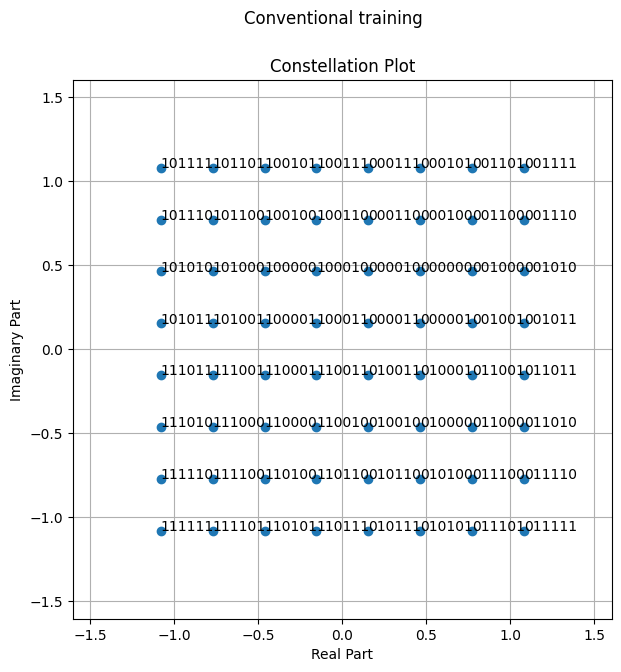

In [103]:
model_conventional = E2ESystemConventionalTraining(training=True)
load_weights(model_conventional, model_weights_path_conventional_training)
fig = model_conventional.constellation.show()
fig.suptitle('Conventional training');

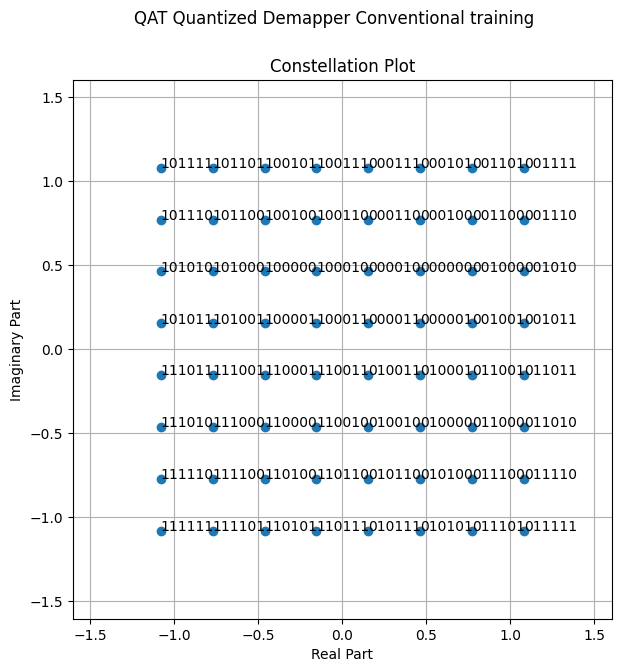

In [104]:
model_quantized = E2ESystemConventionalTrainingQat(training=True)
model_quantized._demapper = QuantizedDemapperWrapper("quantized_demapper.tflite")
load_weights(model_quantized, model_weights_path_quantized_conventional_training)

fig = model_quantized.constellation.show()
fig.suptitle('QAT Quantized Demapper Conventional training');

In [105]:
# model_rl = E2ESystemRLTraining(training=False)
# load_weights(model_rl, model_weights_path_rl_training)
# fig = model_rl.constellation.show()
# fig.suptitle('RL-based training');

In [106]:
# %rm awgn_autoencoder_weights_conventional_training awgn_autoencoder_weights_rl_training awgn_autoencoder_results

## References

[1] T. O’Shea and J. Hoydis, "An Introduction to Deep Learning for the Physical Layer," in IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017, doi: 10.1109/TCCN.2017.2758370.

[2] S. Cammerer, F. Ait Aoudia, S. Dörner, M. Stark, J. Hoydis and S. ten Brink, "Trainable Communication Systems: Concepts and Prototype," in IEEE Transactions on Communications, vol. 68, no. 9, pp. 5489-5503, Sept. 2020, doi: 10.1109/TCOMM.2020.3002915.

[3] F. Ait Aoudia and J. Hoydis, "Model-Free Training of End-to-End Communication Systems," in IEEE Journal on Selected Areas in Communications, vol. 37, no. 11, pp. 2503-2516, Nov. 2019, doi: 10.1109/JSAC.2019.2933891.